<br/>
# Question I :  National Supported Work Demonstration (Propensity score matching)
<br/>
<br/>

**Review HW4 at https://silvrduck.github.io/CS-401/
or directly at our jupyter notebook in the HW4 folder.**


We will work with a by-now classic dataset from Robert LaLonde's study "<a href="http://people.hbs.edu/nashraf/LaLonde_1986.pdf">Evaluating the Econometric Evaluations of Training Programs</a>" (1986). The study investigated the effect of a job training program ("National Supported Work Demonstration") on the real earnings of an individual, a couple of years after completion of the program. Your task is to determine the effectiveness of the "treatment" represented by the job training program.
<br/>
<br/>
<br/>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('ggplot')

### 1. A naive analysis

In [2]:
dataset = pd.read_csv("lalonde.csv")
dataset.groupby('treat').mean()

,age,educ,black,hispan,married,nodegree,re74,re75,re78
treat,,,,,,,,,
0,28.030303,10.235431,0.202797,0.142191,0.512821,0.596737,5619.236506,2466.484443,6984.169742
1,25.816216,10.345946,0.843243,0.059459,0.189189,0.708108,2095.573689,1532.055314,6349.143530


In [3]:
def draw_earning_78_plot(dataset):

    treatedGroup = dataset[dataset['treat'] == 1]
    controlGroup = dataset[dataset['treat'] == 0]
    meanByTreat = dataset.groupby('treat').mean()

    fig = plt.figure(figsize=(15, 20))
    fig.subplots_adjust(hspace=0.3)

    bins = np.linspace(min(controlGroup['re78'].min(), treatedGroup['re78'].min()), max(controlGroup['re78'].max(), treatedGroup['re78'].max()), 25)
    t = plt.subplot(3,2,1)
    tmp = controlGroup['re78'].plot.hist(by='re78', bins=bins, normed=True, label='Control group')
    tmp.set_title('real earning per group in 1978', fontsize=11)
    tmp.set_xlabel('real earning in 1978')
    tmp = treatedGroup['re78'].plot.hist(by='re78', bins=bins, normed=True,  alpha=0.5, label='Treated group')
    t.legend(loc='upper right')
    
    plt.subplot(3,2,3)
    tmp = controlGroup[['re78']].boxplot(showfliers=False)
    tmp.set_title('real earning in CONTROL group', fontsize=11)
    
    plt.subplot(3,2,4)
    tmp = treatedGroup[['re78']].boxplot(showfliers=False)
    tmp.set_title('real earning in TREATED group', fontsize=11)
    tmp.set_ylabel('real earning in 1978')

    plt.subplot(3,2,5)
    tmp = meanByTreat['re78'].copy()
    tmp.index = ['CONTROL', 'TREATED']
    tmp = tmp.plot(kind='bar');
    tmp.set_title('real earning mean comparison', fontsize=11)


    plt.show()

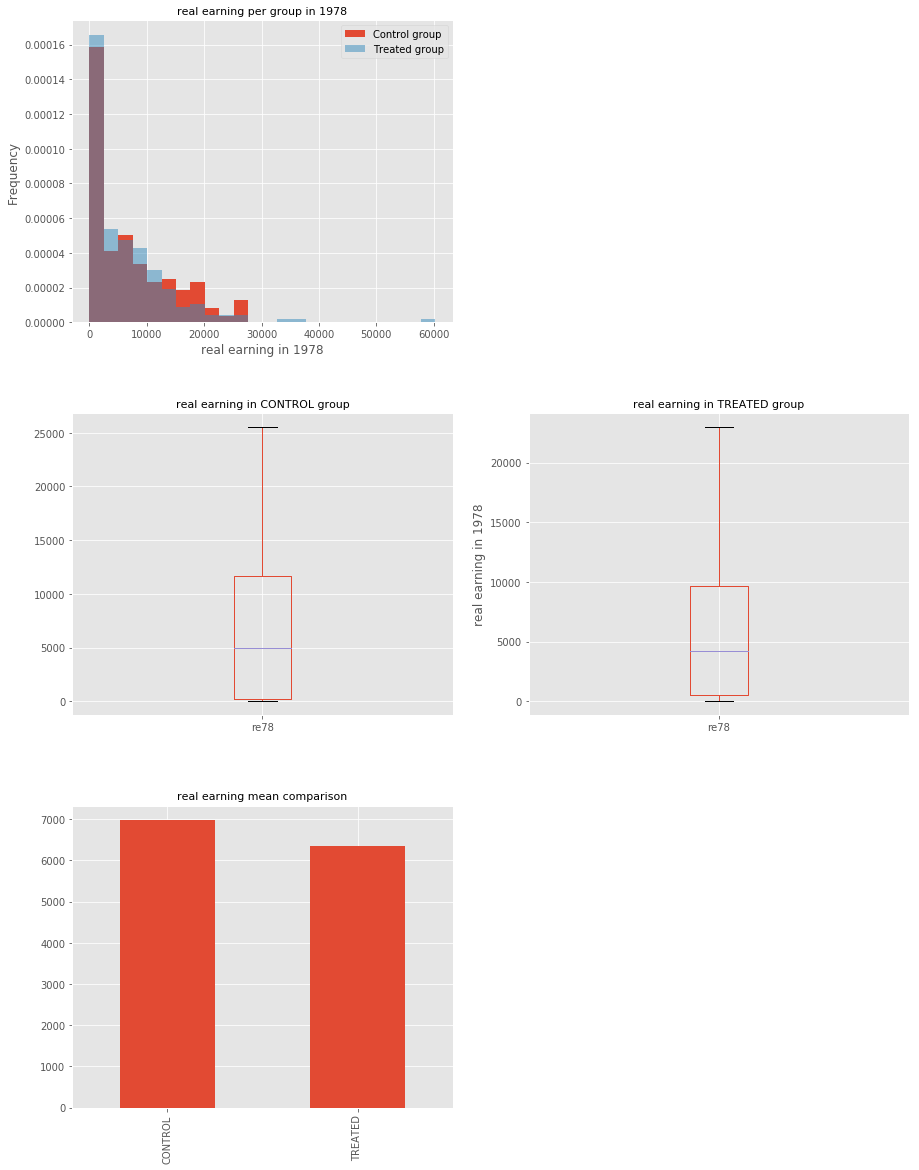

In [4]:
draw_earning_78_plot(dataset)

** Our first naive conclusion **
<br/>
<br/>
The control group has an higher revenue than the treated group. <br/>
The naive analysis would be to conclude that following a training course decreases the revenue.<br/>

### 2. A closer look at the data

Intuitively, we understand that the control group and the treated group are not drawn randomly from the population,
therefore we have to investigate more on the features to see if there are disparities between the 2 categories. 


In [5]:
def build_mean_chart(meanValues, columnName):
    tmp = meanValues[columnName]
    tmp.index = ['CONTROL', 'TREATED']
    tmp = tmp.plot(kind='bar')
    tmp.set_title(columnName+' mean comparison')

    
def draw_feature_disparities_plot(dataset):
    
    meanByTreat = dataset.groupby('treat').mean()
        
    fig = plt.figure(figsize=(20, 20))
    fig.subplots_adjust(hspace=0.7)
    
    plt.subplot(3,3,1)
    build_mean_chart(meanByTreat, 'age')

    plt.subplot(3,3,2)
    build_mean_chart(meanByTreat, 'educ')

    plt.subplot(3,3,3)
    build_mean_chart(meanByTreat, 'black')

    plt.subplot(3,3,4)
    build_mean_chart(meanByTreat, 'hispan')

    plt.subplot(3,3,5)
    build_mean_chart(meanByTreat, 'married')

    plt.subplot(3,3,6)
    build_mean_chart(meanByTreat, 'nodegree')

    plt.subplot(3,3,7)
    build_mean_chart(meanByTreat, 're74')

    plt.subplot(3,3,8)
    build_mean_chart(meanByTreat, 're75')

    plt.show()



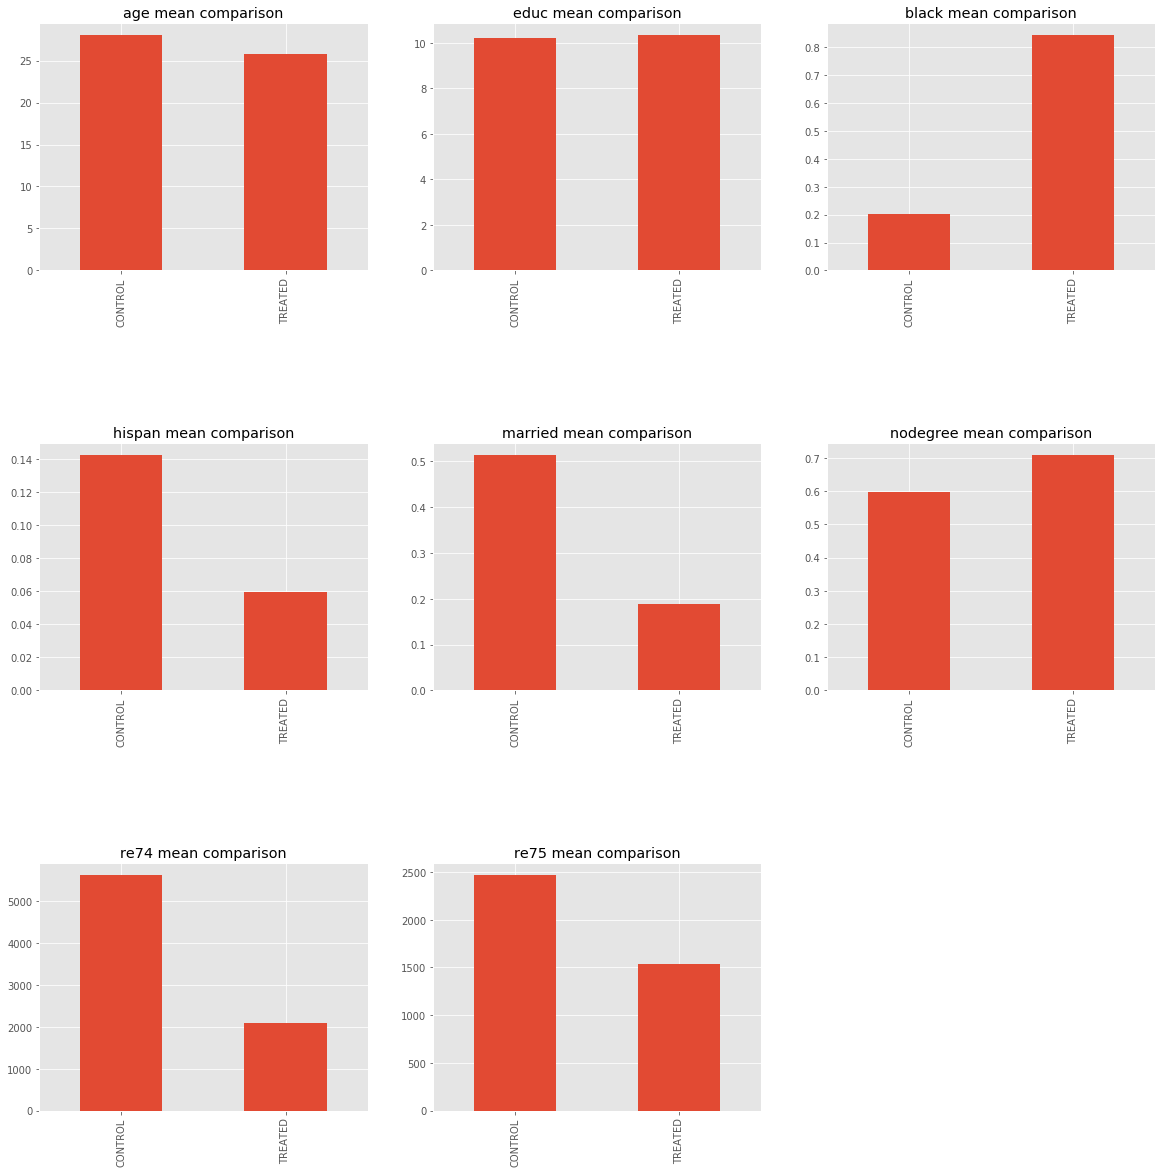

In [6]:
draw_feature_disparities_plot(dataset)

We can see that the control group and the treated one seems to be different.<br/>
To insure this property more fundamentally, we should verify this using confidence interval.<br/>
<br/>
However, many features seems to show obvious disparities, we noticed the black and the hispanic people
mean percentage are completely different. We also noticed that the married mean percentage and the re75/re76
shows really differents values.<br/>
<br/>
Therefore the naive conlusion is not relevant because we can't conclude anything about the accuracy of the training program if the treated group and the control group are different. 

### 3. A propensity score model
<br/>
We try to rebuild our control group such that it represents the same population as the treated group (at least on the given features).<br/>
With this process, the two dataset will be comparable because the exemple will be drawn randomly over the same population.<br/> 
<br/>
We have to build a classifier to estimate the probability than a exemple is in control group or in treated group to decorelate the features from the category : <br/>
If the treated group was drawn randomly the classifier should not learn anything about the category of the data.<br/>
This is why the accuracy should be 50%.
<br/>
<br/>
**Let see if this is the case :**


In [7]:
from sklearn import linear_model
from math import fabs
import networkx as nx

In [8]:
def logistic_analysis(data_set, set_propensity=False):
    logistic = linear_model.LogisticRegression()
    logistic.fit(data_set.loc[:,'age':'re75'], data_set.loc[:,'treat'])
    propensityScores = logistic.predict_proba(data_set.loc[:,'age':'re75'])[:, 1]
    if (set_propensity):
        data_set['propensityScore'] = propensityScores
    hasError = np.logical_xor( propensityScores > 0.5, data_set.loc[:,'treat'] > 0.5 )
    print("has error : "+str(float(hasError.sum()/hasError.shape[0]*100))+"% of the time")

In [9]:
logistic_analysis(dataset, set_propensity=True)

has error : 19.218241042345277% of the time


The classifier can learn about the features and succeed to predict with 80% accuracy the group.
Let use the propensity score and matching to better balance the dataset. 

### 4. Balancing the dataset via matching

In [10]:
G = nx.DiGraph()

for treatedId, treatedRecord in dataset[dataset['treat']==1].iterrows():
    for controlId, controlRecord in dataset[dataset['treat']==0].iterrows():
        absDistance = fabs(treatedRecord['propensityScore']-controlRecord['propensityScore']);
        G.add_edge(controlId, treatedId, weight=-absDistance);

matchings = nx.max_weight_matching(G,  maxcardinality=True)

In [11]:
ids = [currId for currId in matchings.values()]
balancedDataset = dataset.iloc[ids,:]

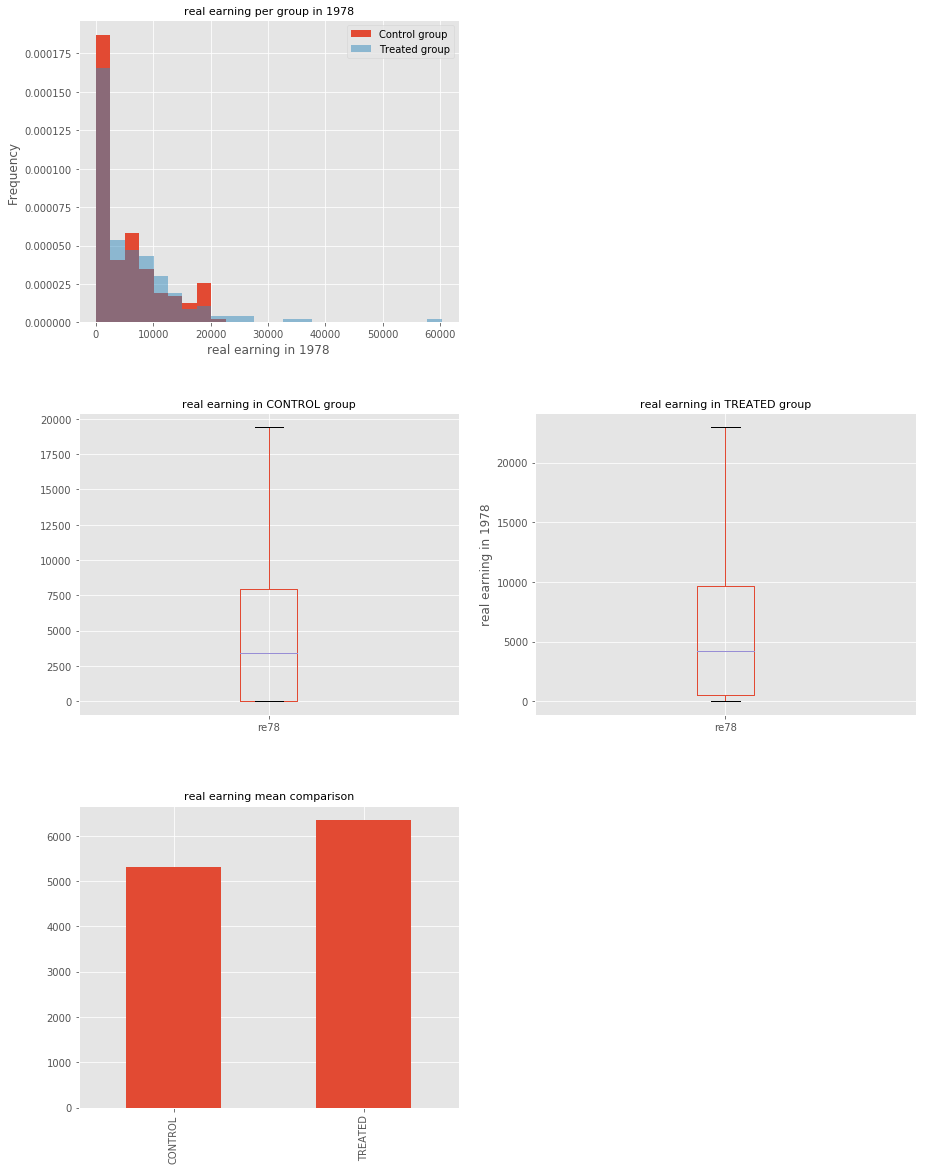

In [12]:
draw_earning_78_plot(balancedDataset)

Those plots are very differents from the one showed in part 2. Now that the group are more or less balanced we see less differences between the treated and the control group. The earnings in the treated group seems to be higher than the one in the control group.

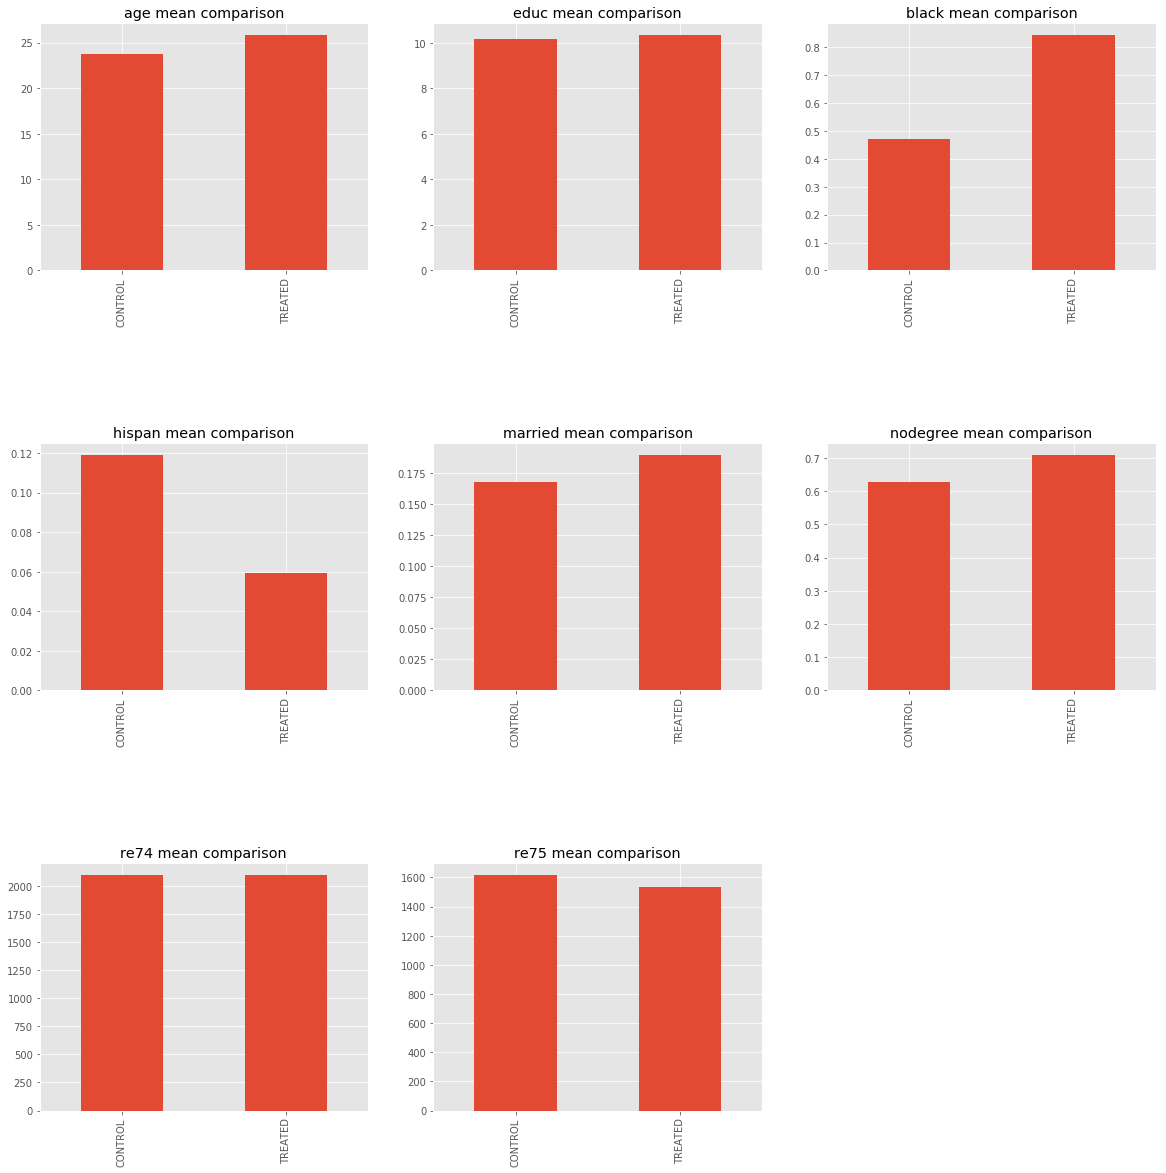

In [13]:
draw_feature_disparities_plot(balancedDataset)

This time the features is much more balanced, but there is still disparities. <br/>
Black/Hispanic mean percentage are still completely differents.<br/>
<br/>
Otherwise, we noticed that now, the training program seems to increase the revenue. 
<br/>
### 5. Balancing the groups further
<br/>
To balance the groups further, on the matching algorithm we decided to only add an edge between people having the same ehtnic group to insure that the black and the hispanic will be perfectly balanced.

In [14]:
G = nx.DiGraph()

for treatedId, treatedRecord in dataset[dataset['treat']==1].iterrows():
    for controlId, controlRecord in dataset[dataset['treat']==0].iterrows():
        if treatedRecord['hispan'] == controlRecord['hispan'] and treatedRecord['black']==controlRecord['black']:
            absDistance = fabs(treatedRecord['propensityScore']-controlRecord['propensityScore'])        
            G.add_edge(controlId, treatedId, weight=-absDistance);

matchings = nx.max_weight_matching(G,  maxcardinality=True)

In [15]:
ids = [currId for currId in matchings.values()]
balancedDataset2 = dataset.iloc[ids,:]

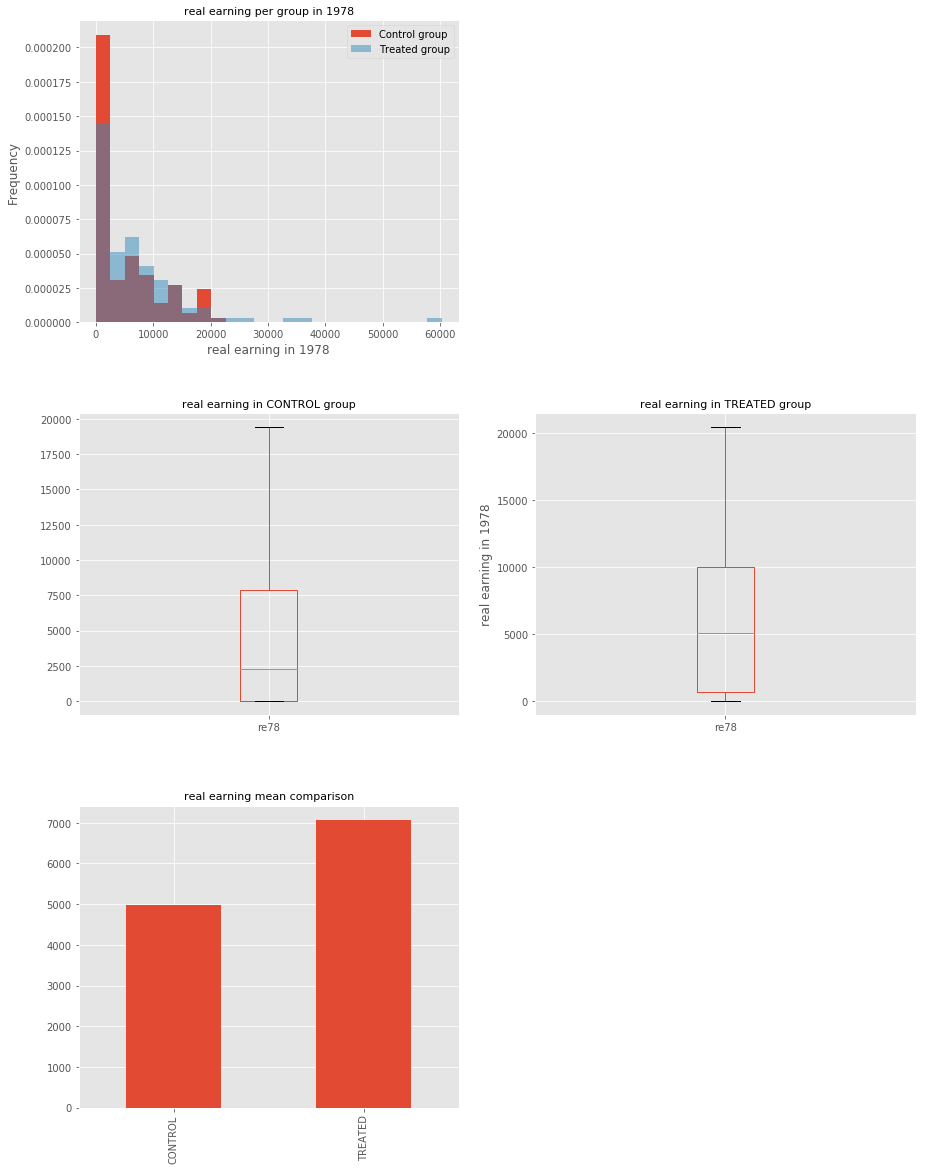

In [16]:
draw_earning_78_plot(balancedDataset2)

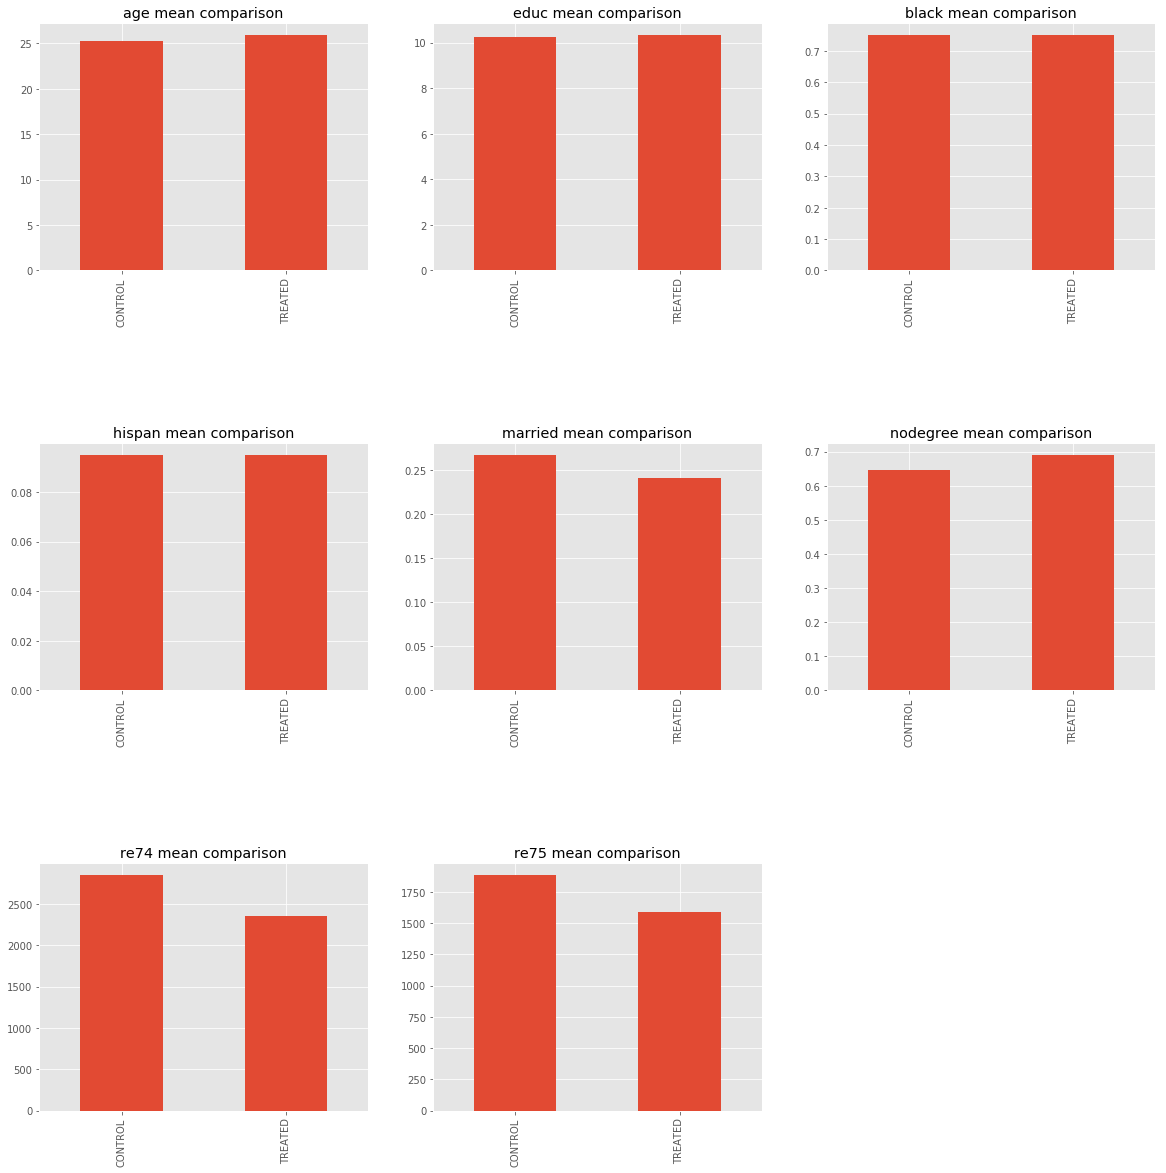

In [17]:
draw_feature_disparities_plot(balancedDataset2)

### 6. A less naive analysis

The analysis we obtain in 5 is much more relevant to make a conclusion about job train efficiency.<br/>
This time the result seems to show that job training increases the revenue of the treated group from 5000 to 7000.


In [18]:
logistic_analysis(balancedDataset2)

has error : 44.396551724137936% of the time


**Last note about features**<br/>
<br/>
On the first dataset (unbalanced), we obtain 20% error rate : 80% accuracy<br/>
On the last dataset (well balanced), we obtain 43% error rate : 57% accuracy <br/>
<br/>
We can see that the classifier has much more trouble to find the category. <br/>
<br/>

# Question II : Applied ML

We are going to build a classifier of news to directly assign them to 20 news categories. 

In [19]:
import sklearn
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
import numpy as np
import matplotlib.pyplot as plt
import itertools
plt.style.use('ggplot')

As we don't know if the data from sklearn are ordered in any way, we decided to shuffle them in order to make sure it has great statistical properties

In [20]:
dataset = fetch_20newsgroups(subset='all')
dataset.data, dataset.filenames, dataset.target = sklearn.utils.shuffle(dataset.data, dataset.filenames, dataset.target)

The first step when doing ML is to split the original dataset into a training dataset, which will be used to train the network, and a validation dataset, that will be used to test the network on new inputs, never submitted before.

In [21]:
def splitDataset(dataset, tf_idf, fromPercent, untilPercent):
    fromId = int(fromPercent*len(dataset.data))
    untilId = int(untilPercent*len(dataset.data))
    return type('Dataset', (object,), {
        "data": dataset.data[fromId:untilId], 
        "filenames": dataset.filenames[fromId:untilId],
        "categoryId": dataset.target[fromId:untilId],
        "tf_idf": tf_idf[fromId:untilId]
    })


vectorizer = TfidfVectorizer()
tf_idf = vectorizer.fit_transform(dataset.data)

trainset = splitDataset(dataset, tf_idf, 0, 0.8)
testset = splitDataset(dataset, tf_idf, 0.8, 0.9)
validation = splitDataset(dataset, tf_idf, 0.9, 1)


The 3 datasets : trainset/validation/testset are now built with the attributes : <br/>
-data : list of article<br/>
-filnames : list of title<br/>
-categoryId : list of category<br/>
-tf_idf : tf/idf matrix<br/>

In [22]:
"trainset articles length : " + str(len(trainset.data))+"   tf-idf matrix shape : "+str(trainset.tf_idf.shape)

'trainset articles length : 15076   tf-idf matrix shape : (15076, 173762)'

Now that we splitted our dataset in three parts, we can train our RandomForest classifier

In [23]:
def trainClassifier(trainset, n_estimators, max_depth):
    classifier = RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth)
    classifier.fit(trainset.tf_idf, trainset.categoryId)
    return classifier

def getAccuracy(classifier, testset):
    testPrediction = classifier.predict(testset.tf_idf)
    return (testPrediction == testset.categoryId).sum()/testPrediction.shape[0]

def parametersTuning(trainset, testset, n_estimator_range, max_depth_range, step):
    bestAccuracy = 0
    best_n_estimator = -1
    best_max_depth = -1
    for n_estimator in range(n_estimator_range[0],n_estimator_range[1], step):
        for max_depth in range(max_depth_range[0],max_depth_range[1], step):
            classifier = trainClassifier(trainset, n_estimator, max_depth)
            curr_accuracy = getAccuracy(classifier, testset)
            if curr_accuracy > bestAccuracy:
                best_n_estimator = n_estimator
                best_max_depth = max_depth
                bestAccuracy = curr_accuracy
            
    return best_n_estimator, best_max_depth, bestAccuracy


In [24]:
n_estimator, max_depth, accuracy = parametersTuning(trainset, validation, [20,60], [20,60], 5)

In [25]:
print("n_estimator = "+str(n_estimator)+" \t max_depth = "+str(max_depth)+"\t accuracy="+str(accuracy))

n_estimator = 55 	 max_depth = 55	 accuracy=0.806366047745


note : the n_estimator value is at the boundary, we could still tunes the random forest a bit. 

In [26]:
""" backup values"""
n_estimator = 55
max_depth = 45
""" -------------"""
classifier = trainClassifier(trainset, n_estimator, max_depth)

In [27]:
right_prediction_percentage = getAccuracy(classifier, testset)
"the right predicted class percentage (in 19 distinct categories) is: "+str(int(right_prediction_percentage*100))+"%"

'the right predicted class percentage (in 19 distinct categories) is: 78%'

In [28]:
confusion_matrix = sklearn.metrics.confusion_matrix(testset.categoryId, classifier.predict(testset.tf_idf))

The goal of the confusion matrix is to evaluate the performance of a classifier, it will highlight the mistakes made by the classifier regarding each category. The better the classifier is, the higher the score in the diagonal will be (meaning that the classifier predicted the correct label)

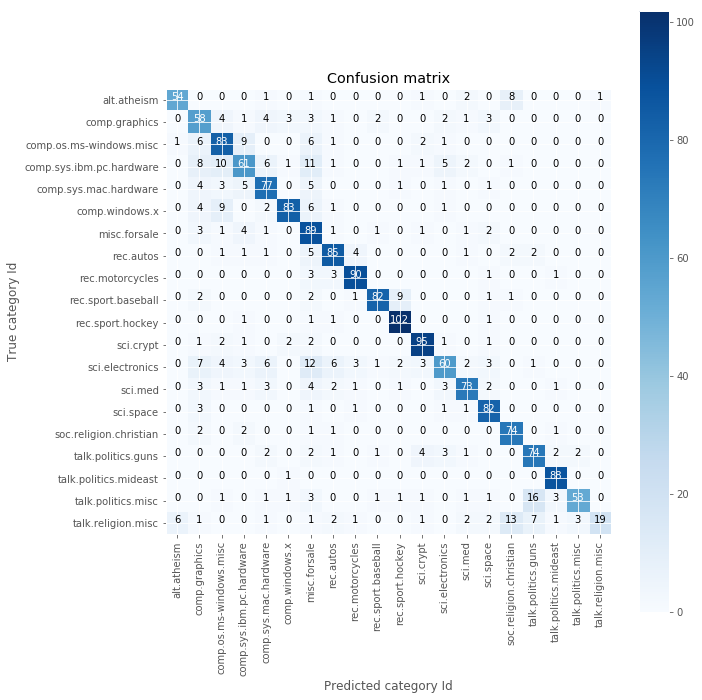

In [96]:
"""
This function is largely inspired from :
http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html 
"""
def confusion_matrix_plot(cm, classes,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    plt.figure(figsize=(10, 10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, dataset.target_names, rotation=90)
    plt.yticks(tick_marks, dataset.target_names)
    fmt = 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True category Id')
    plt.xlabel('Predicted category Id')
    plt.show()

confusion_matrix_plot(confusion_matrix, range(20));


As we can see here, our classifier has pretty good results, in most of the cases it predicted to correct category ID. We see a confusion between quite logical classes, like religion.christian and religion.misc for example.

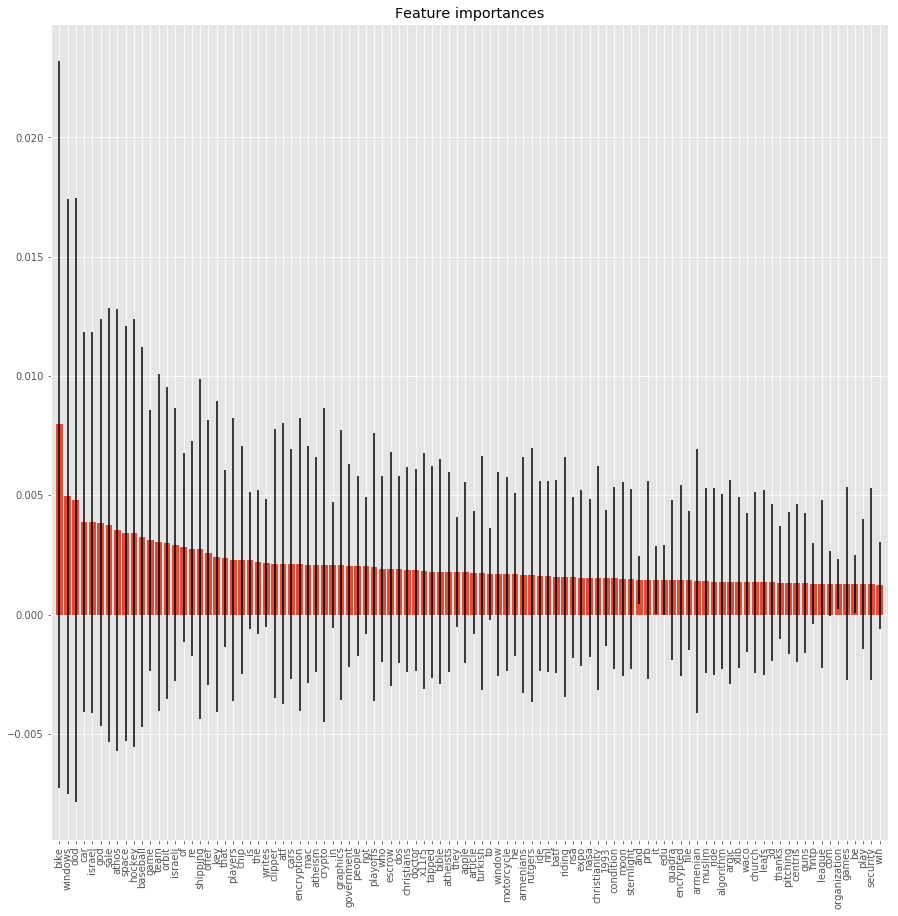

In [58]:
"""
This code is largely inspired from :
http://scikit-learn.org/stable/auto_examples/ensemble/plot_forest_importances.html
"""
total_features_represented = 100;
importances = classifier.feature_importances_
feature_values = vectorizer.get_feature_names()
std = np.std([tree.feature_importances_ for tree in classifier.estimators_], axis=0)
indices = np.argsort(importances)[::-1][:total_features_represented]
plt.figure(figsize=(15, 15))
plt.title("Feature importances")
plt.bar(range(total_features_represented), importances[indices], color="#e34a33", yerr=std[indices], align="center")
plt.xticks(range(total_features_represented), np.asarray(feature_values)[indices], rotation=90)
plt.xlim([-1, total_features_represented])
plt.show()


This graph shows that certain words are better to differentiate between classes. Our top word is bike. It probably means that articles with the word “bike” in it are almost certainly motorcylces articles. 